# Brain Tumor Classification

In this notebook, I'll be going through step by step on how we can develop a model for unstructured data like images. Since our data is non-tabular, a neural network would be more suitable to handle the data. We will try to train our own model first , then try implementing a transfer learning based approach later!

## Exploratory Data Analysis

In [13]:
# First let's unzip the file


# importing the zipfile module 
from zipfile import ZipFile 
  
# loading the temp.zip and creating a zip object 
with ZipFile("./Brain-Tumor-Files.zip", 'r') as zObject: 
  
    # Extracting all the members of the zip  
    # into a specific location. 
    zObject.extractall() 

What we have for data is a bunch of images of cases where there is a brain tumor (y=1) and there isn't a brain tumor (y=0). To carry out exploratory Data Analysis on our image data, we will have to:

1. Resize all images so it is the same size

In [3]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import  ImageDataGenerator as Imgen
from tqdm import tqdm
import os
import cv2

In [4]:
def load_data(dir_path, img_size=(100, 100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []  # List to store images
    y = []  # List to store corresponding labels
    i = 0    # Counter for labels
    labels = dict()  # Dictionary to map labels to indices

    # Loop through each subdirectory in the specified directory
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path  # Map index 'i' to the label 'path'
            
            # Loop through each file in the subdirectory
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    # Read, resize, and append the image to the list 'X'
                    img_path = os.path.join(dir_path, path, file)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, img_size)  # Resize the image
                    X.append(img)
                    
                    # Append the corresponding label index 'i' to the list 'y'
                    y.append(i)
            i += 1

    # Convert lists 'X' and 'y' to NumPy arrays
    X = np.array(X)
    y = np.array(y)

    # Print information about the loaded images
    print(f'{len(X)} images loaded from {dir_path} directory.')

    # Return the image data (X), labels (y), and a dictionary mapping indices to labels
    return X, y, labels

# Add this line to ensure the function returns values
x, y, labels = load_data("./brain_tumor_dataset/", img_size=(224, 224))


100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

253 images loaded from ./brain_tumor_dataset/ directory.


In [5]:
x, y, label = load_data("./brain_tumor_dataset/", img_size=(224,224))

100%|██████████| 2/2 [00:00<00:00,  4.81it/s]

253 images loaded from ./brain_tumor_dataset/ directory.


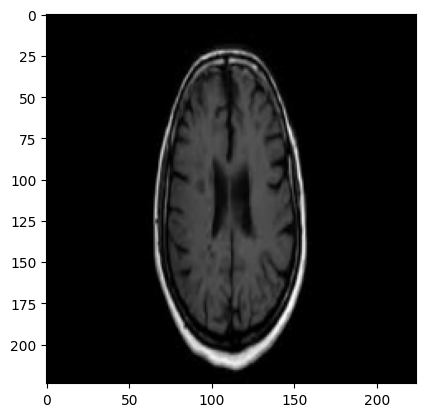

In [40]:
plt.imshow(x[2])

In [42]:
x.shape

(253, 224, 224, 3)

In [14]:
# TESTING CELL
import os
from sklearn.model_selection import train_test_split
from shutil import copyfile

# Define the root directory containing subdirectories for each class
root_directory = './brain_tumor_dataset/'

# Define the output directories for train and test sets
output_directory = '../Tumor-Classification/'

# Get a list of all class directories
class_directories = [os.path.join(root_directory, d) for d in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, d))]

# Loop through each class directory and split into train and test sets
for class_dir in class_directories:
    class_name = os.path.basename(class_dir)
    
    # Get a list of all images in the class directory
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.jpg', '.png'))]
    
    # Split the images into train and test sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Create output directories for train and test sets
    train_class_dir = os.path.join(output_directory, 'train', class_name)
    test_class_dir = os.path.join(output_directory, 'test', class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)
    
    # Copy images to train directory
    for train_img in train_images:
        copyfile(train_img, os.path.join(train_class_dir, os.path.basename(train_img)))
    
    # Copy images to test directory
    for test_img in test_images:
        copyfile(test_img, os.path.join(test_class_dir, os.path.basename(test_img)))


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories for your training and validation datasets
train_dir = './train/'

# Define image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Create a simple CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10
)

# Save the trained model
model.save('../Tumor-Classification/')


Found 137 images belonging to 2 classes.


Epoch 1/10
4/4 [==============================] - 4s 410ms/step - loss: 0.8629 - accuracy: 0.4762
Epoch 2/10
4/4 [==============================] - 2s 452ms/step - loss: 0.6765 - accuracy: 0.5234
Epoch 3/10
4/4 [==============================] - 2s 525ms/step - loss: 0.6770 - accuracy: 0.6484
Epoch 4/10
4/4 [==============================] - 2s 416ms/step - loss: 0.6510 - accuracy: 0.6484
Epoch 5/10
4/4 [==============================] - 1s 331ms/step - loss: 0.6251 - accuracy: 0.6190
Epoch 6/10
4/4 [==============================] - 1s 311ms/step - loss: 0.6147 - accuracy: 0.6667
Epoch 7/10
4/4 [==============================] - 1s 401ms/step - loss: 0.5629 - accuracy: 0.7238
Epoch 8/10
4/4 [==============================] - 1s 315ms/step - loss: 0.6521 - accuracy: 0.6667
Epoch 9/10
4/4 [==============================] - 2s 429ms/step - loss: 0.6322 - accuracy: 0.6762
Epoch 10/10
4/4 [==============================] - 1s 384ms/step - loss: 0.6170 - accuracy: 0.6667
INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: ../Tumor-Classification/assets


In [17]:
from tensorflow.keras.preprocessing import image

# Load and preprocess a new image for prediction
new_image_path = './test/yes/Y1.jpg'
img = image.load_img(new_image_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale pixel values to [0, 1]

# Make a prediction
prediction = model.predict(img_array)

# Print the prediction
if prediction[0][0] > 0.5:
    print("The image is in the positive class (Class 1).")
else:
    print("The image is in the negative class (Class 0).")

1/1 [==============================] - 0s 24ms/step
The image is in the positive class (Class 1).


In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

for test_img_path in test_images:
        # Load image
        img = load_img('./test/', target_size=(150, 150))  # Adjust target_size as per your model's input size
        img_array = img_to_array(img)
        img_array = img_array.reshape((1, *img_array.shape))
        
        # Make prediction
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction)
        
        # Get ground truth label from the image path
        ground_truth_class = class_name  # Assuming class name is part of the image path
        
        # Plot the image with prediction and ground truth
        plt.imshow(img)
        plt.title(f'Predicted: {predicted_class}, Ground Truth: {ground_truth_class}')
        plt.show()

PermissionError: [Errno 13] Permission denied: './test/'